#Semantic Segmentation using SegNet (VGG16 & ResNet50)
## Submitted By: Muhammad Jawad Bashir
##Registration No: 330295

###1. Loading Data

In [1]:
# For loading gdrive on colab
from google.colab import drive
import os

if os.path.exists('/content/gdrive')==False:
    drive.mount('/content/gdrive')
    print('Google Drive is mounted\n')
else:
    print('Google Drive is already mounted\n')

Mounted at /content/gdrive
Google Drive is mounted



###2. Library Installation

In [2]:
# !pip install imgaug==0.2.9
#!pip install keras-segmentation
#!pip install --target='/content/gdrive/MyDrive/Colab Notebooks' keras-segmentation

In [2]:
import glob
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow import keras
import imgaug as ia
from imgaug import augmenters as iaa

###3. Custom Metrics
Dice Coeffecient is not implemented in library. Library module 'train.py' has been modified to include it. Ony IU Score and Crossentropy is implemented in library.

In [3]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

###4. DataLoader
Dataset's train folder is splitted into train-validation (0.8 & 0.2) using split-folder library and splitted dataset is uploaded on GDrive for ease of work with this library.We can also use the following function.

In [5]:

# def Data_Loader(images_path, masks_path):
#         train_images = []

#         for directory_path in glob.glob(images_path):
#             for img_path in glob.glob(os.path.join(directory_path, "*.png")):
#                 #print(img_path)
#                 img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
#                 #img = cv2.resize(img, (SIZE_Y, SIZE_X))
#                 #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
#                 train_images.append(img)
#                 #train_labels.append(label)
#         #Convert list to array for machine learning processing        
#         train_images = np.array(train_images)

#         #Capture mask/label info as a list
#         train_masks = [] 
#         for directory_path in glob.glob(masks_paths):
#             for mask_path in glob.glob(os.path.join(directory_path, "*.png")):
#                 mask = cv2.imread(mask_path, 0)       
#                 #mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
#                 #mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
#                 train_masks.append(mask)
#                 #train_labels.append(label)
#         #Convert list to array for machine learning processing          
#         train_masks = np.array(train_masks)

#         #Use customary x_train and y_train variables
#         X = train_images
#         Y = train_masks
#         Y = np.expand_dims(Y, axis=3) #May not be necessary.. leftover from previous code
#         return X, Y

In [6]:
# train_images = "/content/gdrive/MyDrive/dataset1/images_prepped_train"
# tain_masks = "/content/gdrive/MyDrive/dataset1/annotations_prepped_train"
# X, Y = Data_Loader(train_images, train_masks)
# from sklearn.model_selection import train_test_split
#         x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

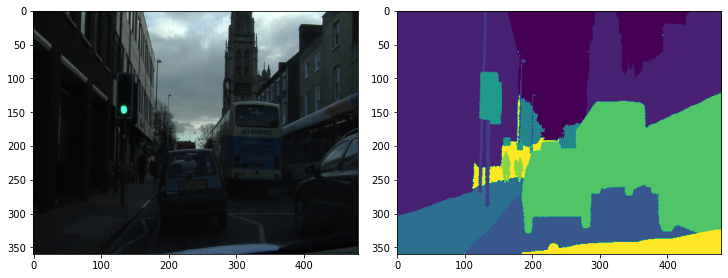

In [7]:
original_image = "/content/gdrive/MyDrive/Datasets/dataset1_splitted/images_prepped_train/0001TP_006690.png"
label_image_semantic = "/content/gdrive/MyDrive/Datasets/dataset1_splitted/annotations_prepped_train/0001TP_006690.png"

fig, axs = plt.subplots(1, 2, figsize=(10, 8), constrained_layout=True)

axs[0].imshow( Image.open(original_image))
axs[0].grid(False)

label_image_semantic = Image.open(label_image_semantic)
label_image_semantic = np.asarray(label_image_semantic)
axs[1].imshow(label_image_semantic)
axs[1].grid(False)

###5. Library Path
Library is installed in my drive for modification and ease of access instead of installing it on every run.

In [8]:
import sys
nb_path = '/content/gdrive/MyDrive/Colab Notebooks'
#os.symlink('/content/gdrive/MyDrive/Colab Notebooks', nb_path)
sys.path.insert(0,nb_path)

In [9]:
import keras_segmentation

###6. SegNet with VGG-16 Backbone

In [10]:
from keras_segmentation.models.segnet import vgg_segnet

model_vgg = vgg_segnet(n_classes = 11, input_height=320, input_width=640 )

In [11]:
# !pip install split-folders
# import split-folders
# splitfolders.ratio("input_folder", output="output", seed=1337, ratio=(.8, .2), group_prefix=None)

###7. Custom Data Augmentation
Augmentation function is also manually modified in library and then used.

In [12]:
def aug_ment():
    return iaa.OneOf([
        iaa.Sequential([iaa.Fliplr(0.5), iaa.Flipud(0.2)]),
        iaa.CropAndPad(percent=(-0.05, 0.1),
                       pad_mode='constant',
                       pad_cval=(0, 255)),
        iaa.Crop(percent=(0.0, 0.1)),
        iaa.Crop(percent=(0.3, 0.5)),
        iaa.Crop(percent=(0.3, 0.5)),
        iaa.Crop(percent=(0.3, 0.5)),
        iaa.Sequential([
            iaa.Affine(
                    # scale images to 80-120% of their size,
                    # individually per axis
                    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                    # translate by -20 to +20 percent (per axis)
                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                    rotate=(-45, 45),  # rotate by -45 to +45 degrees
                    shear=(-16, 16),  # shear by -16 to +16 degrees
                    # use nearest neighbour or bilinear interpolation (fast)
                    order=[0, 1],
                    # if mode is constant, use a cval between 0 and 255
                    mode='constant',
                    cval=(0, 255),
                    # use any of scikit-image's warping modes
                    # (see 2nd image from the top for examples)
            ),
                   iaa.Sometimes(0.2, iaa.GaussianBlur(sigma=(0, 3.0))),
                   iaa.Sometimes(0.2, iaa.MotionBlur(k=15, angle=[-45, 45])),
                   iaa.Sometimes(0.2, iaa.MultiplyHue((0.5, 1.5))),
                   iaa.Sometimes(0.2, iaa.MultiplySaturation((0.5, 1.5))),
                   iaa.Sometimes(0.34, iaa.MultiplyHueAndSaturation((0.5, 1.5),
                                                         per_channel=True)),])
    ])

In [13]:
#model.add_metric()
#model.train()
batch_size = 8

history_vgg = model_vgg.train(
    train_images =  "/content/gdrive/MyDrive/Datasets/dataset1_splitted/images_prepped_train/",
    train_annotations = "/content/gdrive/MyDrive/Datasets/dataset1_splitted/annotations_prepped_train/",
    validate=True,
    val_images="/content/gdrive/MyDrive/Datasets/dataset1_splitted/images_prepped_valid",
    val_annotations="/content/gdrive/MyDrive/Datasets/dataset1_splitted/annotations_prepped_valid",
    checkpoints_path = "/tmp/vgg_segnet_111" , 
    epochs=30,
    do_augment=True, # enable augmentation, 
    augmentation_name = 'aug_all',
    verify_dataset=False,
    batch_size = batch_size,
    val_batch_size = batch_size,
    steps_per_epoch = np.ceil(294 / batch_size),
    val_steps_per_epoch = np.ceil(73 / batch_size),
    )

/content/gdrive/MyDrive/Colab Notebooks/keras_segmentation/train.py:170: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  use_multiprocessing=gen_use_multiprocessing)
/usr/local/lib/python3.7/dist-packages/imgaug/augmenters/segmentation.py:191: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  segments = segmentation.slic(image, n_segments=n_segments_samples[i], compactness=10)


Epoch 1/30
37/37 [==============================] - 205s 5s/step - loss: 2.7549 - accuracy: 0.1470 - dice_coef: 0.1112 - val_loss: 3.7094 - val_accuracy: 0.1890 - val_dice_coef: 0.1805
Epoch 2/30
37/37 [==============================] - 128s 4s/step - loss: 2.1531 - accuracy: 0.3537 - dice_coef: 0.2012 - val_loss: 2.0021 - val_accuracy: 0.4084 - val_dice_coef: 0.3340
Epoch 3/30
37/37 [==============================] - 129s 3s/step - loss: 1.7407 - accuracy: 0.4896 - dice_coef: 0.3026 - val_loss: 1.4064 - val_accuracy: 0.5788 - val_dice_coef: 0.4608
Epoch 4/30
37/37 [==============================] - 131s 4s/step - loss: 1.5211 - accuracy: 0.5608 - dice_coef: 0.3760 - val_loss: 1.1176 - val_accuracy: 0.6605 - val_dice_coef: 0.5428
Epoch 5/30
37/37 [==============================] - 123s 3s/step - loss: 1.3215 - accuracy: 0.6166 - dice_coef: 0.4410 - val_loss: 0.9731 - val_accuracy: 0.7006 - val_dice_coef: 0.5954
Epoch 6/30
37/37 [==============================] - 126s 3s/step - loss: 1.

###8. Results for SegNet (VGG-16)

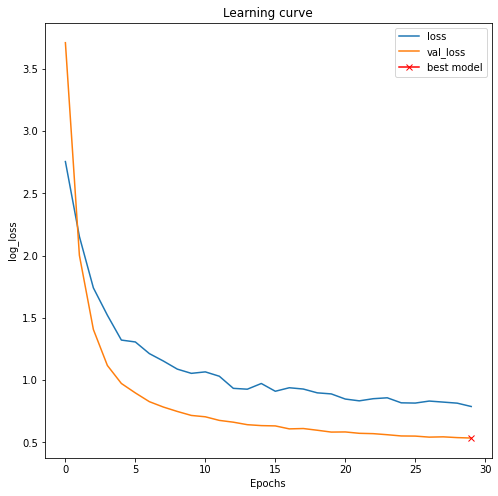

In [14]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(model_vgg.history.history["loss"], label="loss")
plt.plot(model_vgg.history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(model_vgg.history.history["val_loss"]), np.min(model_vgg.history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();
plt.show()
#plt.savefig('/tmp/'+str(config['Model'])+'/train_loss.png')

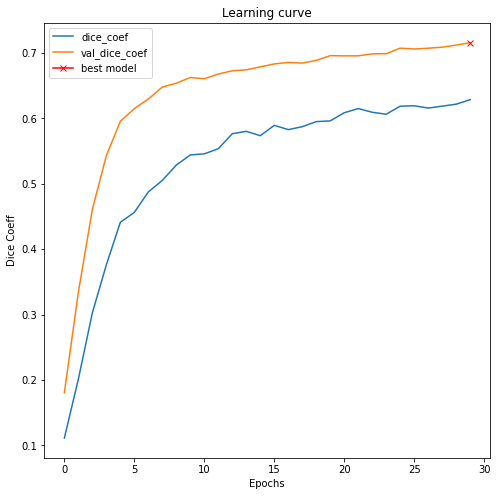

In [15]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(model_vgg.history.history["dice_coef"], label="dice_coef")
plt.plot(model_vgg.history.history["val_dice_coef"], label="val_dice_coef")
plt.plot( np.argmax(model_vgg.history.history["val_dice_coef"]), np.max(model_vgg.history.history["val_dice_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Dice Coeff")
plt.legend();
plt.show()
#plt.savefig('./Results/plots/'+str(config['Model'])+'/train_dice.png')

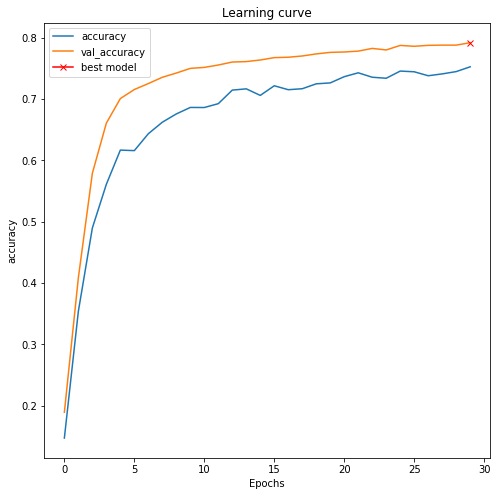

In [16]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(model_vgg.history.history["accuracy"], label="accuracy")
plt.plot(model_vgg.history.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmax(model_vgg.history.history["val_accuracy"]), np.max(model_vgg.history.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend();
plt.show()
# plt.savefig('./Results/plots/'+str(config['Model'])+'/train_accuracy.png

In [17]:
print(model_vgg.evaluate_segmentation( 
    inp_images_dir="/content/gdrive/MyDrive/Datasets/dataset1_splitted/annotations_prepped_test"  , 
    annotations_dir="/content/gdrive/MyDrive/Datasets/dataset1_splitted/images_prepped_test",
    ) 
)

101it [00:52,  1.93it/s]

{'frequency_weighted_IU': 0.39333882789083585, 'mean_IU': 0.03656461466636201, 'class_wise_IU': array([4.00092075e-01, 1.07921100e-05, 0.00000000e+00, 1.18310719e-04,
       1.27893593e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.37198577e-03, 4.37144820e-04, 5.25596552e-05])}


In [18]:
his_vgg = model_vgg.history

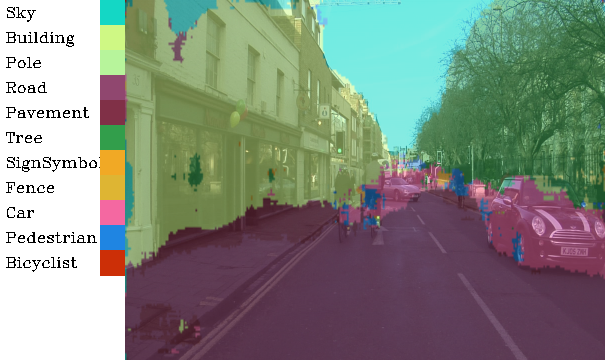

In [19]:
pred_img = model_vgg.predict_segmentation(
    inp="/content/gdrive/MyDrive/Datasets/dataset1_splitted/images_prepped_test/0016E5_07965.png",
    out_fname="/tmp/pred_img.png", overlay_img=True, show_legends=True,
    class_names = [ "Sky", "Building", "Pole","Road","Pavement","Tree","SignSymbol", "Fence", "Car","Pedestrian", "Bicyclist"]
)

from IPython.display import Image
Image('/tmp/pred_img.png')

###9. SegNet with ResNet50 Backbone

In [20]:
from keras_segmentation.models.segnet import resnet50_segnet
model_res = resnet50_segnet(n_classes = 11, input_height=320, input_width=640 )

In [21]:
#model2.summary()

In [22]:
batch_size= 8
history_res = model_res.train(
    train_images =  "/content/gdrive/MyDrive/Datasets/dataset1_splitted/images_prepped_train/",
    train_annotations = "/content/gdrive/MyDrive/Datasets/dataset1_splitted/annotations_prepped_train/",
    validate=True,
    val_images="/content/gdrive/MyDrive/Datasets/dataset1_splitted/images_prepped_valid",
    val_annotations="/content/gdrive/MyDrive/Datasets/dataset1_splitted/annotations_prepped_valid",
    checkpoints_path = "/tmp/res_segnet_2001" , 
    epochs=30,
    do_augment=True, # enable augmentation 
    augmentation_name = 'aug_all',
    verify_dataset=False,
    batch_size = batch_size,
    val_batch_size = batch_size,
    steps_per_epoch = np.ceil(294 / batch_size),
    val_steps_per_epoch = np.ceil(73 / batch_size),
    )

/content/gdrive/MyDrive/Colab Notebooks/keras_segmentation/train.py:170: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  use_multiprocessing=gen_use_multiprocessing)
/usr/local/lib/python3.7/dist-packages/imgaug/augmenters/segmentation.py:191: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  segments = segmentation.slic(image, n_segments=n_segments_samples[i], compactness=10)


Epoch 1/30
37/37 [==============================] - 129s 3s/step - loss: 2.6102 - accuracy: 0.1438 - dice_coef: 0.1184 - val_loss: 2.5849 - val_accuracy: 0.1388 - val_dice_coef: 0.1294
Epoch 2/30
37/37 [==============================] - 125s 3s/step - loss: 2.1202 - accuracy: 0.2871 - dice_coef: 0.1877 - val_loss: 1.8723 - val_accuracy: 0.3198 - val_dice_coef: 0.2288
Epoch 3/30
37/37 [==============================] - 124s 3s/step - loss: 1.7981 - accuracy: 0.4139 - dice_coef: 0.2584 - val_loss: 1.4596 - val_accuracy: 0.4816 - val_dice_coef: 0.3284
Epoch 4/30
37/37 [==============================] - 119s 3s/step - loss: 1.5875 - accuracy: 0.4944 - dice_coef: 0.3152 - val_loss: 1.1964 - val_accuracy: 0.5806 - val_dice_coef: 0.4097
Epoch 5/30
37/37 [==============================] - 126s 3s/step - loss: 1.4327 - accuracy: 0.5533 - dice_coef: 0.3663 - val_loss: 1.0311 - val_accuracy: 0.6449 - val_dice_coef: 0.4742
Epoch 6/30
37/37 [==============================] - 118s 3s/step - loss: 1.

###10. Results with SegNet (ResNet-50 backbone)

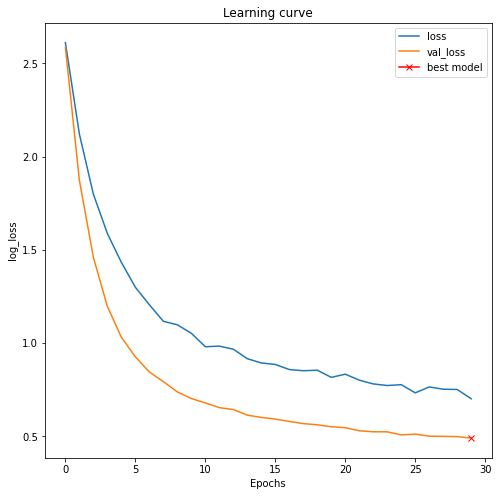

In [23]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(model_res.history.history["loss"], label="loss")
plt.plot(model_res.history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(model_res.history.history["val_loss"]), np.min(model_res.history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();
plt.show()
#plt.savefig('/tmp/'+str(config['Model'])+'/train_loss.png')

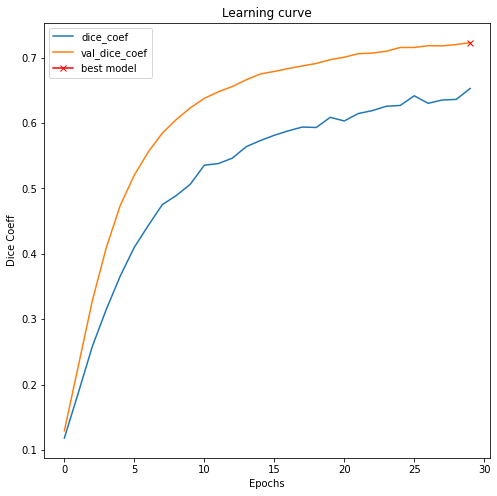

In [24]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(model_res.history.history["dice_coef"], label="dice_coef")
plt.plot(model_res.history.history["val_dice_coef"], label="val_dice_coef")
plt.plot( np.argmax(model_res.history.history["val_dice_coef"]), np.max(model_res.history.history["val_dice_coef"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Dice Coeff")
plt.legend();
plt.show()
#plt.savefig('./Results/plots/'+str(config['Model'])+'/train_dice.png')

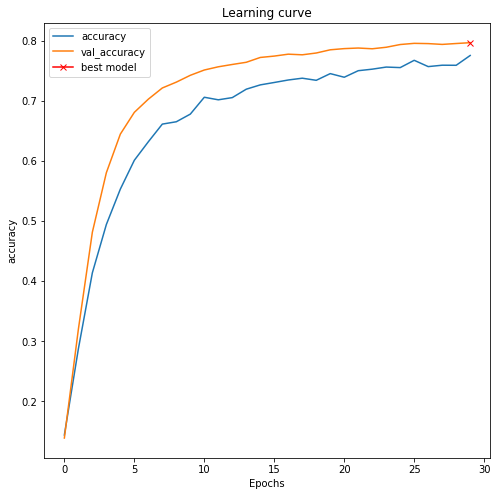

In [25]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(model_res.history.history["accuracy"], label="accuracy")
plt.plot(model_res.history.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmax(model_res.history.history["val_accuracy"]), np.max(model_res.history.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend();
plt.show()
# plt.savefig('./Results/plots/'+str(config['Model'])+'/train_accuracy.png

In [26]:
his_res = model_res.history

In [ ]:
print(model_res.evaluate_segmentation( 
    inp_images_dir="/content/gdrive/MyDrive/Datasets/dataset1_splitted/annotations_prepped_test"  , 
    annotations_dir="/content/gdrive/MyDrive/Datasets/dataset1_splitted/images_prepped_test",
    ) 
)

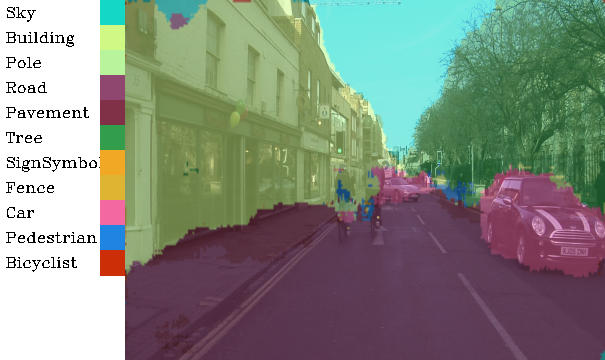

In [27]:
pred_img_res = model_res.predict_segmentation(
    inp="/content/gdrive/MyDrive/Datasets/dataset1_splitted/images_prepped_test/0016E5_07965.png",
    out_fname="/tmp/pred_img_res.png", overlay_img=True, show_legends=True,
    class_names = [ "Sky", "Building", "Pole","Road","Pavement","Tree","SignSymbol", "Fence", "Car","Pedestrian", "Bicyclist"]
)

from IPython.display import Image
Image('/tmp/pred_img_res.png')

###11. Predicting all the test examples using checkpoints of VGG-16 and ResNet-50

In [ ]:
from keras_segmentation.predict import predict_multiple


predict_multiple( 
	checkpoints_path="/tmp/vgg_segnet_111", 
	inp_dir="/content/gdrive/MyDrive/Datasets/dataset1_splitted/annotations_prepped_test", 
	out_dir="outputs_vgg/" 
)

In [ ]:
from keras_segmentation.predict import predict_multiple


predict_multiple( 
	checkpoints_path="/tmp/res_segnet_2001", 
	inp_dir="/content/gdrive/MyDrive/Datasets/dataset1_splitted/annotations_prepped_test", 
	out_dir="outputs_res/" 
)